In [1]:
import os
import os.path
import sys

p_mod=os.path.join(os.environ['HOME'],'notebooks/99MyModules')
sys.path.append(p_mod)

## 1. ライブラリのインポート
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors
 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
print(rdBase.rdkitVersion) # 2019.03.2

2019.03.2


In [2]:
import descarray as da

In [3]:
df_AMES=pd.read_csv('./ci900161g_si_001/smiles_cas_N6512.smi',sep='\t', header=None)
df_AMES.columns = ['smiles', 'CAS_NO', 'activity']
da.descDf(df_AMES)

サイズ:(6512, 3)


,smiles,CAS_NO,activity
0,O=C1c2ccccc2C(=O)c3c1ccc4c3[nH]c5c6C(=O)c7cccc...,2475-33-4,0
1,NNC(=O)CNC(=O)\C=N\#N,820-75-7,1
2,O=C1NC(=O)\C(=N/#N)\C=N1,2435-76-9,1
3,NC(=O)CNC(=O)\C=N\#N,817-99-2,1
4,CCCCN(CC(O)C1=C\C(=N/#N)\C(=O)C=C1)N=O,116539-70-9,1


サイズ:(6506, 5)


,smiles,CAS_NO,activity,ROMol,mw
0,O=C1c2ccccc2C(=O)c3c1ccc4c3[nH]c5c6C(=O)c7ccccc7C(=O)c6c8[nH]c9c%10C(=O)c%11ccccc%11C(=O)c%10ccc9c8c45,2475-33-4,0,,646.614
7,CC(=O)OC1(CCC2C3C=C(Cl)C4=CC(=O)OCC4(C)C3CCC12C)C(=O)C,105149-00-6,0,,406.906
8,Nc1nc(N)nc(N)n1,108-78-1,0,,126.123
9,Cc1ccc(N=Nc2c(O)ccc3ccccc23)c(c1)[N+](=O)[O-],2425-85-6,1,,307.309
10,CC(C)CC(=O)Nc1snc2ccccc12,67019-24-3,0,,234.324

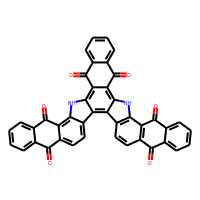
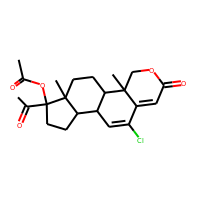
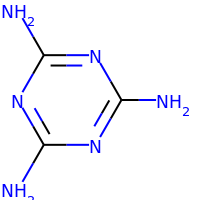
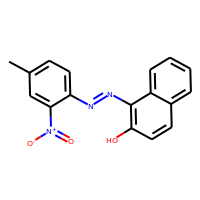
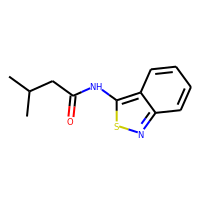

In [5]:
PandasTools.AddMoleculeColumnToFrame(frame=df_AMES, smilesCol='smiles')
## 4. 読み込めない分子の削除
df_AMES_d=df_AMES.dropna()
df_AMES_d=df_AMES_d.assign(mw=df_AMES_d['ROMol'].map(Descriptors.MolWt))#.map(Descriptors.MolWt)
da.descDf(df_AMES_d)

In [6]:
print('全部で%d'%len(df_AMES_d)) # 6506
n_neg=np.sum(df_AMES_d.activity == 0)
n_pos=np.sum(df_AMES_d.activity == 1)
print('陰性は{}、陽性は{}'.format(n_neg,n_pos))

全部で6506
陰性は3009、陽性は3497


In [7]:
maccskeys = []
for mol in df_AMES_d.ROMol:
    maccskey = [i for i in AllChem.GetMACCSKeysFingerprint(mol)]
    maccskeys.append(maccskey)
maccskeys = np.array(maccskeys)
print(maccskeys.shape) # (6506, 167)
## 出力ラベル
target = df_AMES_d.activity
print(target.shape) # (6506,)

(6506, 167)
(6506,)


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(maccskeys, df_AMES_d.activity, random_state=0)
 
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print('accuracy on train set: {:.3f}'.format(tree.score(X_train, y_train)))
print('accuracy on test set: {:.3f}'.format(tree.score(X_test, y_test)))

accuracy on train set: 0.976
accuracy on test set: 0.750


In [17]:
accs_train = []
accs_test = []
 
for i in range(1,21):
    tree_i = DecisionTreeClassifier(max_depth=i, random_state=0)
    tree_i.fit(X_train, y_train)
    acc_train = tree_i.score(X_train, y_train)
    acc_test = tree_i.score(X_test, y_test)
    accs_train.append(acc_train)
    accs_test.append(acc_test)

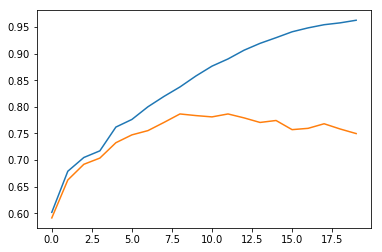

In [22]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(accs_train)
ax.plot(accs_test)

In [23]:
tree2 = DecisionTreeClassifier(max_depth=2)
tree2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [24]:
from sklearn.tree import export_graphviz
export_graphviz(tree2, out_file='tree2.dot', class_names=['negative', 'positive'],
                feature_names=range(1,168), filled=True)

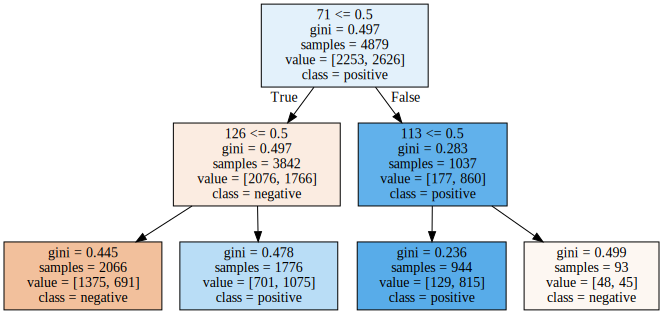

In [26]:
import graphviz
with open('tree2.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)